# <center><font color=blue>Credit Approval</font>

<font color=blue size=4>1-Needed Packages

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pylab as plt
import sklearn.metrics as sk
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from collections import defaultdict
from itertools import chain, combinations
from copy import deepcopy
from IPython.display import display
# pip install datawig
import datawig

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'

/home/labib/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


<font color=blue size=4>2- Load Data</font> 

In [2]:
## In case of using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# file = '/content/drive/MyDrive/Colab Notebooks/crx.data.csv'
datasetOriginal = pd.read_csv('data/crx.data.csv', header=None)
print('Dataset initial state:')
display(datasetOriginal.head(30))
display(datasetOriginal.tail(30))
display(datasetOriginal.describe())
display(datasetOriginal.info())

Dataset initial state:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,00360,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,00164,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,00080,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,00180,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,00052,1442,+


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
660,b,22.25,9.000,u,g,aa,v,0.085,f,f,0,f,g,00000,0,-
661,b,29.83,3.500,u,g,c,v,0.165,f,f,0,f,g,00216,0,-
662,a,23.50,1.500,u,g,w,v,0.875,f,f,0,t,g,00160,0,-
663,b,32.08,4.000,y,p,cc,v,1.500,f,f,0,t,g,00120,0,-
664,b,31.08,1.500,y,p,w,v,0.040,f,f,0,f,s,00160,0,-
665,b,31.83,0.040,y,p,m,v,0.040,f,f,0,f,g,00000,0,-
666,a,21.75,11.750,u,g,c,v,0.250,f,f,0,t,g,00180,0,-
667,a,17.92,0.540,u,g,c,v,1.750,f,t,1,t,g,00080,5,-
668,b,30.33,0.500,u,g,d,h,0.085,f,f,0,t,s,00252,0,-
669,b,51.83,2.040,y,p,ff,ff,1.500,f,f,0,f,g,00120,1,-


,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
0     690 non-null object
1     690 non-null object
2     690 non-null float64
3     690 non-null object
4     690 non-null object
5     690 non-null object
6     690 non-null object
7     690 non-null float64
8     690 non-null object
9     690 non-null object
10    690 non-null int64
11    690 non-null object
12    690 non-null object
13    690 non-null object
14    690 non-null int64
15    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


None

<font color=blue size=4>3- Clean Data</font> 

In [3]:
# Name columns.
datasetOriginal.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",
                           "N", "O", "is_approved"]

# Analyze data types based on type of data, as its not always correctly recognized.
# Feature B has an object type but clearly the values are numerical.
floatType = 'float'
intType = 'int'
nonObjectDataTypes = {
   "B": floatType,
   "C": floatType,
   "H": floatType,
   "K": intType,
   "O": intType,
}

continuousDataColumns = list(nonObjectDataTypes.keys())
categoricalDataColumns = np.setdiff1d(datasetOriginal.columns,continuousDataColumns)

# Make data more suitable for learning by converting labels to 0,1
datasetOriginal['is_approved'].replace({"+": 1, "-": 0}, inplace=True)

# Gather missing data columns and their data types
missingDataColumns = {}
continuousType = 'continuous'
categoricalType = 'categorical'
for column in datasetOriginal.columns:
    if (datasetOriginal[column] == '?').any():
        if column in nonObjectDataTypes:
            dataType = continuousType
        else:
            dataType = categoricalType
        missingDataColumns[column] = dataType
        # replace missing value with NaN
        datasetOriginal[column] = datasetOriginal[column].replace('?', np.nan)

# all variations will be collected here, beside saving in csv files
datasets = {
    "original": datasetOriginal
}

print('\nMissing data columns:')
display(missingDataColumns)
print('\nMissing data rows count per column:')
display(datasetOriginal.isnull().sum())


Missing data columns:


/home/labib/anaconda3/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


{'A': 'categorical',
 'B': 'continuous',
 'D': 'categorical',
 'E': 'categorical',
 'F': 'categorical',
 'G': 'categorical',
 'N': 'categorical'}


Missing data rows count per column:


A              12
B              12
C               0
D               6
E               6
F               9
G               9
H               0
I               0
J               0
K               0
L               0
M               0
N              13
O               0
is_approved     0
dtype: int64

<font color=blue size=4>4- Handling Missing Data </font>
    
<font color=grey size=3>4.1- Remove rows with missing data.</font>

<font color=grey size=3>4.2- Fill continuous data with columns mean/median values and categorical data with columns most frequent category.</font> 

<font color=grey size=3>4.3- Fill based on predictive models between mostly correlated columns.</font> 

<font color=grey size=3>4.4- Fill using unsupervised learning.</font> 

<font color=grey size=3>4.5- Fill using deep learning.</font> 

<font color=blue size=4>4.1- Remove rows with missing data</font>

In [4]:
# 4.1. Remove rows with missing data
# Pros:
#  A model trained with the removal of all missing values creates a robust model.
# Cons:
#  Loss of a lot of information.
#  Works poorly if the percentage of missing values is excessive in comparison to the complete dataset.
datasetWithRemovedRows = datasetOriginal.copy(deep=True)
# remove rows where any column has value NaN
datasetWithRemovedRows = datasetWithRemovedRows.dropna()
# set data types correctly after removing rows with NaN
for column in nonObjectDataTypes:
    datasetWithRemovedRows[column] = datasetWithRemovedRows[column].astype(nonObjectDataTypes[column])
# save data to a new csv
datasetWithRemovedRows.to_csv("data/crx.data_removed_missing.csv", index=False, encoding='utf8')
datasets['after removing missing rows'] = datasetWithRemovedRows
# validate rows removal is done correctly
assert datasetWithRemovedRows.isnull().any().any() == False
assert datasetOriginal.shape[0] > datasetWithRemovedRows.shape[0]

print('\nContinuous columns info:')
datasetWithRemovedRows.describe()


Continuous columns info:


,B,C,H,K,O,is_approved
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,31.503813,4.829533,2.244296,2.502297,1013.761103,0.453292
std,11.838267,5.027077,3.371120,4.968497,5253.278504,0.498195
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.580000,1.040000,0.165000,0.000000,0.000000,0.000000
50%,28.420000,2.835000,1.000000,0.000000,5.000000,0.000000
75%,38.250000,7.500000,2.625000,3.000000,400.000000,1.000000
max,76.750000,28.000000,28.500000,67.000000,100000.000000,1.000000


<font color=blue size=4>4.2- Fill continuous data with columns mean values and categorical data with columns most frequent category</font>

In [5]:
# 4.2. Fill continuous data with columns mean values and categorical data with columns most frequent category
# Pros:
#  Prevent data loss which results in deletion of rows or columns.
#  Works well with a small dataset and easy to implement.
# Cons:
#  Can cause data leakage.
#  Does not factor the covariance between features (for continuous ones).
datasetWithCalculatedRows = datasetOriginal.copy(deep=True)
for column in missingDataColumns:
    if missingDataColumns[column] == continuousType:
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
        imp.fit(datasetWithRemovedRows[column].values.reshape(-1, 1))
        datasetWithCalculatedRows[column] = imp.transform(datasetWithCalculatedRows[column].values.reshape(-1, 1))
    else:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(datasetWithRemovedRows[column].values.reshape(-1, 1))
        datasetWithCalculatedRows[column] = imp.transform(datasetWithCalculatedRows[column].values.reshape(-1, 1))
# set data types correctly after calculating rows with NaN
for column in nonObjectDataTypes:
    datasetWithCalculatedRows[column] = datasetWithCalculatedRows[column].astype(nonObjectDataTypes[column])
# save data to a new csv
datasetWithCalculatedRows.to_csv("data/crx.data_calculated_missing.csv", index=False, encoding='utf8')
datasets['after calculating missing rows'] = datasetWithCalculatedRows
# validate rows calculation is done correctly
assert datasetWithCalculatedRows.isnull().any().any() == False
assert datasetOriginal.shape[0] == datasetWithCalculatedRows.shape[0]

print('\nContinuous columns correlation:')
corr = datasetWithRemovedRows.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


Continuous columns correlation:


,B,C,H,K,O,is_approved
B,1,0.22,0.42,0.2,0.029,0.18
C,0.22,1,0.3,0.27,0.12,0.21
H,0.42,0.3,1,0.33,0.052,0.33
K,0.2,0.27,0.33,1,0.058,0.41
O,0.029,0.12,0.052,0.058,1,0.17
is_approved,0.18,0.21,0.33,0.41,0.17,1


<font color=blue size=4>4.3- Fill based on predictive models between mostly correlated columns</font>

Association rules (node=columnName_rowValue)


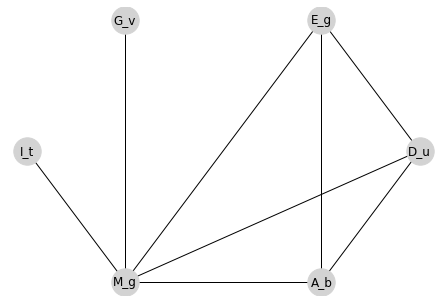

In [6]:
# 4.3. Fill based on predictive models between mostly correlated columns
# Pros:
#  Gives a better result than earlier methods.
#  Takes into account the covariance between missing value column and other columns.
# Cons:
#  Considered only as a proxy for the true values.
datasetWithPredictedRows = datasetOriginal.copy(deep=True)
# Fill continuous-data-type columns based on predictive models between mostly correlated columns
continuousDataColumnsWithoutMissingData = np.append(np.setdiff1d(list(nonObjectDataTypes.keys()),list(missingDataColumns.keys())), 'is_approved')
continuousDataColumnsWithMissingData = np.intersect1d(list(nonObjectDataTypes.keys()), list(missingDataColumns.keys()))
for column in continuousDataColumnsWithMissingData:
    continuousDataColumnsWithoutMissingData = np.append(continuousDataColumnsWithoutMissingData,column)
    continuousDatasetWithRemovedRows = datasetWithRemovedRows[continuousDataColumnsWithoutMissingData]
    continuousDatasetWithPredictedRows = datasetWithPredictedRows[continuousDataColumnsWithoutMissingData]

    xTrain = continuousDatasetWithRemovedRows.drop(column, axis=1)
    yTrain = continuousDatasetWithRemovedRows[column]

    testData = continuousDatasetWithPredictedRows[continuousDatasetWithPredictedRows[column].isnull()]
    xTest = testData.drop(column, axis=1)

    model = LinearRegression()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTest)
    datasetWithPredictedRows[column][datasetWithPredictedRows[column].isnull()] = np.around(yPred, 2)

# Fill nominal-categoricies-data-type columns
# Apriori algorithm is a straight-forward Association rule mining technique
# to identify underlying relations between different items.
#
# Support in Apriori is the Fraction of transactions that contain an itemset.
# So, the support of item I is defined as the number of transactions containing I divided by the total number of transactions.
#
# Confidence in Apriori is how often items in Y appear in transactions that contain X.
# So, the confidence It’s calculated as the number of transactions containing X and Y divided by the number of transactions containing X.
#
# Frequent Item Set in Apriori is simply all the itemsets that the support satisfies the minimum support threshold.
#
# It’s a bottom-up approach. We started from every single item in the itemset list.
# Then, the candidates are generated by self-joining.
# We extend the length of the itemsets one item at a time.
# The subset test is performed at each stage and the itemsets that contain infrequent subsets are pruned.
# We repeat the process until no more successful itemsets can be derived from the data.
def getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
    freqItemSet = set()
    localItemSetWithSup = defaultdict(int)

    for item in itemSet:
        for itemSet in itemSetList:
            if item.issubset(itemSet):
                globalItemSetWithSup[item] += 1
                localItemSetWithSup[item] += 1

    for item, supCount in localItemSetWithSup.items():
        support = float(supCount / len(itemSetList))
        if(support >= minSup):
            freqItemSet.add(item)

    return freqItemSet


def getUnion(itemSet, length):
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def pruning(candidateSet, prevFreqSet, length):
    tempCandidateSet = candidateSet.copy()
    for item in candidateSet:
        subsets = combinations(item, length)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if(frozenset(subset) not in prevFreqSet):
                tempCandidateSet.remove(item)
                break
    return tempCandidateSet

def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

def associationRule(freqItemSet, itemSetWithSup, minConf):
    rules = []
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
            subsets = powerset(item)
            for s in subsets:
                confidence = float(
                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules


def getItemSetFromList(itemSetList):
    tempItemSet = set()

    for itemSet in itemSetList:
        for item in itemSet:
            tempItemSet.add(frozenset([item]))

    return tempItemSet

def apriori(itemSetList, minSup, minConf):
    C1ItemSet = getItemSetFromList(itemSetList)
    # Final result global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    L1ItemSet = getAboveMinSup(
        C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
    currentLSet = L1ItemSet
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        currentLSet = getAboveMinSup(
            candidateSet, itemSetList, minSup, globalItemSetWithSup)
        k += 1

    rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2]*-1)

    return globalFreqItemSet, rules

graph = nx.Graph()
def plotAssociationRules(rules):
    for rule in rules:
        fromNodes = rule[0]
        toNodes = rule[1]
        for fromNode in fromNodes:
            for toNode in toNodes:
                graph.add_nodes_from([fromNode, toNode])
                graph.add_weighted_edges_from([(fromNode, toNode, rule[2])])

categoricalDataColumnsWithoutMissingData = np.setdiff1d(np.setdiff1d(datasetOriginal.columns,list(nonObjectDataTypes.keys())),list(missingDataColumns.keys()))
categoricalDataColumnsWithMissingData = np.setdiff1d(list(missingDataColumns.keys()), list(nonObjectDataTypes.keys()))

for missingDataColumn in categoricalDataColumnsWithMissingData:
    categoricalDataColumnsWithoutMissingData = np.append(categoricalDataColumnsWithoutMissingData,missingDataColumn)
    categoricalDatasetWithRemovedRows = datasetWithRemovedRows[categoricalDataColumnsWithoutMissingData]
    categoricalDatasetWithPredictedRows = datasetWithPredictedRows[categoricalDataColumnsWithoutMissingData]
    # Make each column unique even if there are common values between columns like `t` and `f`
    for column in categoricalDatasetWithRemovedRows:
        categoricalDatasetWithRemovedRows[column] = [column + '_' + str(rowValue) for rowValue in categoricalDatasetWithRemovedRows[column]]
    # Use apriori to collect association rules
    globalFreqItemSet, rules = apriori(categoricalDatasetWithRemovedRows.to_numpy(), 0.5, 0.5)

    plotAssociationRules(rules)
    
    usefulRules = []
    columnUniqueValues = categoricalDatasetWithRemovedRows[column].unique()
    for rule in rules:
        ruleValues = list(rule[0]) + list(rule[1])
        for columnValue in columnUniqueValues:
            # keep rules that include the column with missing data
            if columnValue in ruleValues:
                usefulRules.append(ruleValues)
    # Rename prediction data similarly to training data to be able to match 
    for column in categoricalDatasetWithPredictedRows[categoricalDatasetWithPredictedRows[column].isnull()]:
        if missingDataColumn != column:
            categoricalDatasetWithPredictedRows[column] = [column + '_' + str(rowValue) for rowValue in categoricalDatasetWithPredictedRows[column]]
    # Predict missing data
    # Keep in mind, some rows might still have no clear association rules to predict.
    # We will use most frequent value for those.
    yPred = [];
    stillHaveMissingValues = False
    for row in categoricalDatasetWithPredictedRows[categoricalDatasetWithPredictedRows[column].isnull()].drop(column, axis=1).to_numpy():
        r = len(row)
        matched = False
        # collect all possible combinations of row starting from the whole row to single column values.
        # first match with association rules is used to predict missing column value.
        while(r >= 1 and matched == False):
            for combination in combinations(row, r):
                if matched == False:
                    for rule in usefulRules:
                        if matched == False and len(np.intersect1d(combination,rule)) == len(combination):
                            # get missing column value from association rule
                            matching = [s for s in rule if missingDataColumn in s]
                            # remove added unique string from matched value
                            yPred.append(matching[0].split('_')[-1])
                            # stop looking for matched values for that row
                            matched = True
            r -= 1
        # if no match found, keep value as `NaN`
        if matched == False:
            stillHaveMissingValues = True
            yPred.append(np.nan)
    datasetWithPredictedRows[missingDataColumn][datasetWithPredictedRows[missingDataColumn].isnull()] = yPred
    if stillHaveMissingValues == True:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(datasetWithPredictedRows[missingDataColumn].values.reshape(-1, 1))
        datasetWithPredictedRows[missingDataColumn] = imp.transform(datasetWithPredictedRows[missingDataColumn].values.reshape(-1, 1))
# set data types correctly after predicting rows with NaN
for column in nonObjectDataTypes:
    datasetWithPredictedRows[column] = datasetWithPredictedRows[column].astype(nonObjectDataTypes[column])
# save data to a new csv
datasetWithPredictedRows.to_csv("data/crx.data_predicted_missing.csv", index=False, encoding='utf8')
datasets['after predicting missing rows'] = datasetWithPredictedRows
# validate rows prediction is done correctly
assert datasetWithPredictedRows.isnull().any().any() == False
assert datasetOriginal.shape[0] == datasetWithPredictedRows.shape[0]

# Visualize association rules
print("Association rules (node=columnName_rowValue)")
nx.draw_shell(graph, with_labels=True, node_size=750, node_color="lightgrey")

<font color=blue size=4>4.4- Fill using unsupervised learning.</font>

In [7]:
# 4.4. Fill using unsupervised learning
# Pros:
# Support more non-linearity between data, as it doesn't need strong correlation  
#  Takes into account the covariance between missing value column and other columns.
# Cons:
#  Considered only as a proxy for the true values.
datasetWithUnsupervisedLearntRows = datasetOriginal.copy(deep=True)

categoriesMap = {}
# Convert categorical columns data to ordinal integers
for column in categoricalDataColumns:
    columnUniqueValues = datasetWithUnsupervisedLearntRows[column][datasetWithUnsupervisedLearntRows[column].notnull()].unique()
    categoryMap = ({ index: v for index, v in enumerate(columnUniqueValues) })
    keyList = list(categoryMap.keys())
    valList = list(categoryMap.values())
    categoriesMap[column] = {'keys': keyList, 'values': valList, 'ordinalMap': categoryMap}
    ordinalIntegers = [keyList[valList.index(rowValue)] for rowValue in datasetWithUnsupervisedLearntRows[column] if rowValue == rowValue]
    datasetWithUnsupervisedLearntRows[column][datasetWithUnsupervisedLearntRows[column] == datasetWithUnsupervisedLearntRows[column]] = ordinalIntegers
    
imputer = KNNImputer(n_neighbors=2, weights="uniform")
transformedData = imputer.fit_transform(datasetWithUnsupervisedLearntRows)
rotatedTransformedData = transformedData.T
for index, column in enumerate(datasetWithUnsupervisedLearntRows.columns):
    datasetWithUnsupervisedLearntRows[column] = rotatedTransformedData[index]

# Convert ordinal integers to original categorical columns data
for column in categoricalDataColumns:
    datasetWithUnsupervisedLearntRows[column] = [categoriesMap[column]['ordinalMap'][round(rowValue,0)] for rowValue in datasetWithUnsupervisedLearntRows[column]]

# set data types correctly after unsupervised learning rows with NaN
for column in nonObjectDataTypes:
    datasetWithUnsupervisedLearntRows[column] = datasetWithUnsupervisedLearntRows[column].astype(nonObjectDataTypes[column])
# save data to a new csv
datasetWithUnsupervisedLearntRows.to_csv("data/crx.data_unsupervised_learnt_missing.csv", index=False, encoding='utf8')
datasets['after unsupervised learning missing rows'] = datasetWithUnsupervisedLearntRows
# validate rows unsupervised learning is done correctly
assert datasetWithUnsupervisedLearntRows.isnull().any().any() == False
assert datasetOriginal.shape[0] == datasetWithUnsupervisedLearntRows.shape[0]

<font color=blue size=4>4.5- Fill using deep learning.</font>

In [8]:
# 4.5. Fill using deep learning
# Pros:
#  Quite accurate compared to other methods.
#  It supports both CPUs and GPUs.
# Cons:
#  Still can be quite slow with large datasets.
datasetWithDeepLearntRows = datasetOriginal.copy(deep=True)
columns = datasetWithDeepLearntRows.columns 

for column in missingDataColumns:
    df_train = datasetWithDeepLearntRows.dropna()
    df_test = datasetWithDeepLearntRows[datasetWithDeepLearntRows[column].isnull()]
    # Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=np.delete(columns,np.where(columns == column)), # column(s) containing information about the column we want to impute
        output_column= column, # the column we'd like to impute values for
        output_path = 'imputer_model' # stores model data and metrics
        )

    # Fit an imputer model on the train data
    imputer.fit(train_df=df_train, num_epochs=50)

    # Impute missing values and return original dataframe with predictions
    imputed = imputer.predict(df_test)
    datasetWithDeepLearntRows[column][datasetWithDeepLearntRows[column].isnull()] = imputed[column+'_imputed']

# set data types correctly after deep learning rows with NaN
for column in nonObjectDataTypes:
    datasetWithDeepLearntRows[column] = datasetWithDeepLearntRows[column].astype(nonObjectDataTypes[column])
# save data to a new csv
datasetWithDeepLearntRows.to_csv("data/crx.data_deep_learnt_missing.csv", index=False, encoding='utf8')
datasets['after deep learning missing rows'] = datasetWithDeepLearntRows
# validate rows deep learning is done correctly
assert datasetWithDeepLearntRows.isnull().any().any() == False
assert datasetOriginal.shape[0] == datasetWithDeepLearntRows.shape[0]

2021-02-06 04:07:51,300 [INFO]  NumExpr defaulting to 8 threads.
2021-02-06 04:07:51,573 [INFO]  
========== start: fit model
2021-02-06 04:07:51,574 [WARNING]  Already bound, ignoring bind()
2021-02-06 04:07:51,779 [INFO]  Epoch[0] Batch [0-19]	Speed: 1613.24 samples/sec	cross-entropy=0.726019	A-accuracy=0.656250
2021-02-06 04:07:51,935 [INFO]  Epoch[0] Train-cross-entropy=0.657994
2021-02-06 04:07:51,935 [INFO]  Epoch[0] Train-A-accuracy=0.685811
2021-02-06 04:07:51,938 [INFO]  Epoch[0] Time cost=0.360
2021-02-06 04:07:51,949 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2021-02-06 04:07:52,003 [INFO]  Epoch[0] Validation-cross-entropy=0.511114
2021-02-06 04:07:52,004 [INFO]  Epoch[0] Validation-A-accuracy=0.775000
2021-02-06 04:07:52,201 [INFO]  Epoch[1] Batch [0-19]	Speed: 1655.06 samples/sec	cross-entropy=0.597763	A-accuracy=0.678125
2021-02-06 04:07:52,369 [INFO]  Epoch[1] Train-cross-entropy=0.567319
2021-02-06 04:07:52,370 [INFO]  Epoch[1] Train-A-accuracy=0.722

##### <font color=blue size=4> 5- Preprocessing: Transform Data.</font>

In [9]:
# Transform Categorical data to numeric
def categoricalTransform(dataset):
    for i in dataset.columns:
        if dataset[i].dtypes=='object':
            dataset[i]=LabelEncoder().fit_transform(dataset[i])
    return dataset

# Normalize Continuous data by min/max scaling
def normTransform(dataset):
    for col in continuousDataColumns:
        maximum=dataset[col].max()
        minimum=dataset[col].min()
        dataset[col]=dataset[col].map(lambda a: (a-minimum)/(maximum-minimum))
    return dataset

# Standardize Continuous data 
def standTransform(dataset):
    for col in continuousDataColumns:
        std=dataset[col].std()
        mean=dataset[col].mean()
        dataset[col]=dataset[col].map(lambda a: (a-mean)/std)
    return dataset

# Log Continuous data (should be followed by norm/stand transformation)
def log(x):
    if x == 0:
        x = 1 
    return np.log2(x)
def logTransform(dataset):
    for col in continuousDataColumns:
        dataset[col]=dataset[col].map(log)
    return dataset

In [10]:
datasetWithRemovedRowsAllNumeric = datasetWithRemovedRows.copy(deep=True)
display(categoricalTransform(datasetWithRemovedRowsAllNumeric))
display(datasetWithRemovedRowsAllNumeric.describe())

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,is_approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,68,0,1
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,11,560,1
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,94,824,1
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,31,3,1
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,37,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,2,2,4,3,1.25,0,0,0,0,0,89,0,0
686,0,22.67,0.750,1,0,1,7,2.00,0,1,2,1,0,67,394,0
687,0,25.25,13.500,2,2,5,2,2.00,0,1,1,1,0,67,1,0
688,1,17.92,0.205,1,0,0,7,0.04,0,0,0,0,0,94,750,0


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,is_approved
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,0.689127,31.503813,4.829533,1.229709,0.468606,5.773354,5.084227,2.244296,0.534456,0.439510,2.502297,0.462481,0.165391,55.770291,1013.761103,0.453292
std,0.463206,11.838267,5.027077,0.428193,0.845963,4.296249,2.494278,3.371120,0.499194,0.496708,4.968497,0.498973,0.548475,44.706156,5253.278504,0.498195
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.580000,1.040000,1.000000,0.000000,1.000000,3.000000,0.165000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
50%,1.000000,28.420000,2.835000,1.000000,0.000000,6.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,52.000000,5.000000,0.000000
75%,1.000000,38.250000,7.500000,1.000000,0.000000,10.000000,7.000000,2.625000,1.000000,1.000000,3.000000,1.000000,0.000000,91.000000,400.000000,1.000000
max,1.000000,76.750000,28.000000,2.000000,2.000000,13.000000,8.000000,28.500000,1.000000,1.000000,67.000000,1.000000,2.000000,163.000000,100000.000000,1.000000


##### <font color=blue size=4> 5- Feature Selection </font>

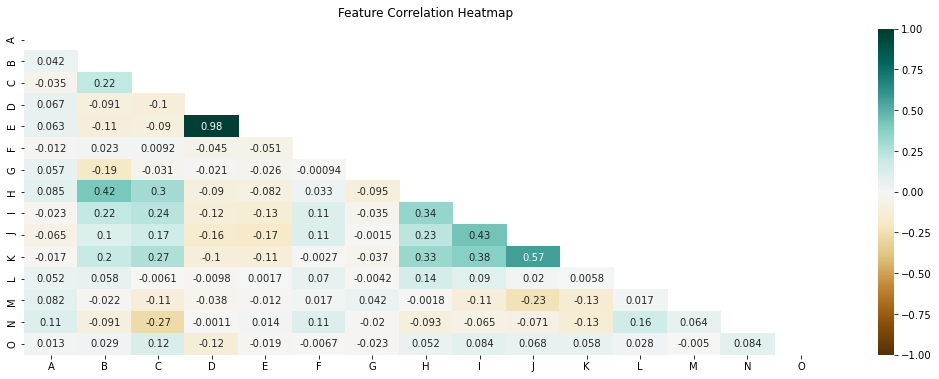

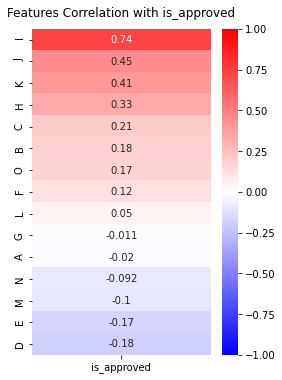

In [11]:
def heatmapFeatures(dataset):
    features_corr = dataset.iloc[:,0:-1].corr()

    plt.figure(figsize=(18, 6))
    mask = np.triu(np.ones_like(features_corr, dtype=np.bool))
    heatmap = sns.heatmap(features_corr,mask = mask,vmin=-1, vmax=1,annot=True,cmap='BrBG')

    heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

def heatmapFeaturesWithOutput(dataset):
  
    corr = dataset.corr().iloc[:, -1].sort_values(ascending=False)
    corr = pd.DataFrame(corr).iloc[1:,:]
    # Heatmap ranking
    plt.figure(figsize=(4, 6))
    heatmap = sns.heatmap(corr,vmin=-1, vmax=1,annot=True,cmap='bwr')

    heatmap.set_title('Features Correlation with {}'.format(dataset.columns[-1]),fontdict={'fontsize':12}, pad=12)



# We can see that D & E are strongly correlated, hence we can drop one of them.
heatmapFeatures(datasetWithRemovedRowsAllNumeric)

# G is the least correlated feature with target, followed by L & A.. hence we will drop them too
heatmapFeaturesWithOutput(datasetWithRemovedRowsAllNumeric)

In [12]:
yColumn = 'is_approved'
dataset = categoricalTransform(datasetWithRemovedRows)
X = dataset.loc[:, dataset.columns != yColumn].values
y = dataset[yColumn].values
X_new = SelectKBest(chi2).fit_transform(X, y)

print("No. of features with least scores:", X.shape[1] - X_new.shape[1])
print("We already caught 4 by manual observation.")

No. of features with least scores: 5
We already caught 4 by manual observation.


<font color=grey size=4>Based on heat maps observations.</font>

<font color=grey size=4>&emsp;We can see that <b>D</b> & <b>E</b> are strongly correlated, hence we can drop one of them.</font> 

<font color=grey size=4>&emsp;<b>G</b> is the least correlated feature with target, followed by <b>L</b> & <b>A</b>.. hence we will drop them too.</font> 

<font color=grey size=4>Based on KBest scores selection.</font>

<font color=grey size=4>&emsp;We can see that <b>5</b> features are removed, which is close to the number we got by manual observation.</font> 

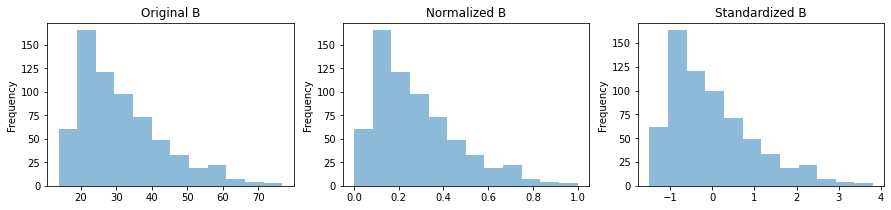

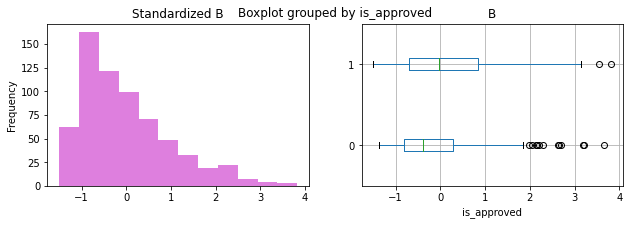

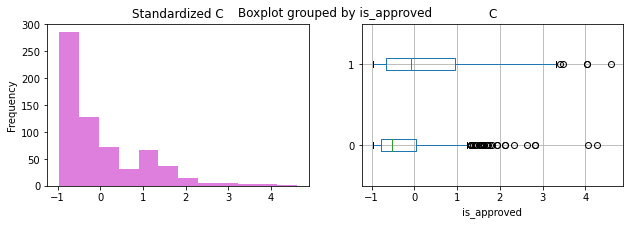

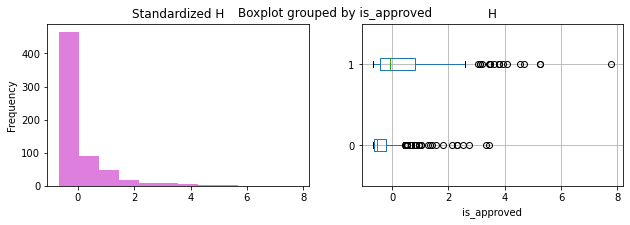

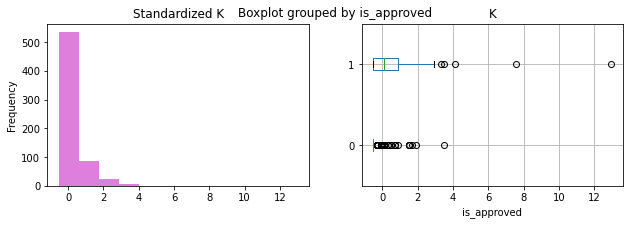

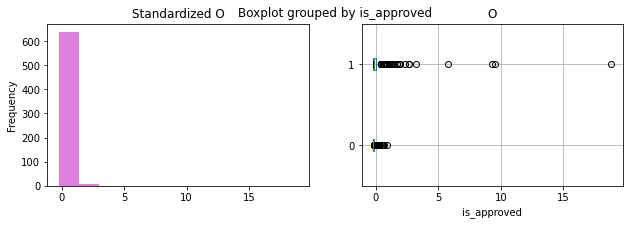

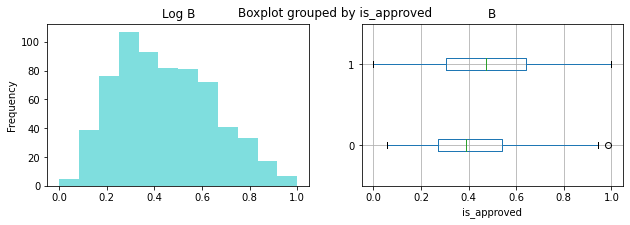

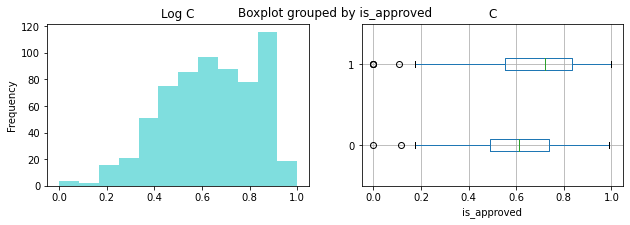

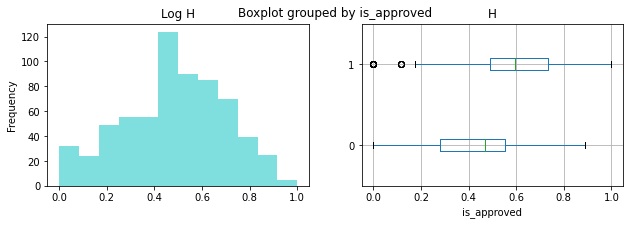

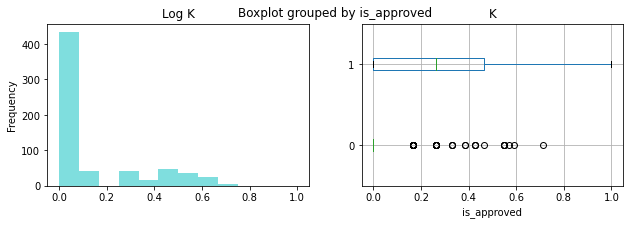

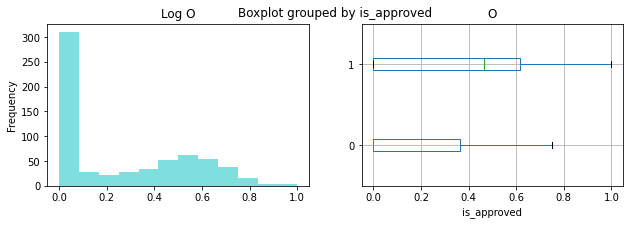

In [13]:
datasetWithRemovedRowsNormTransformed = datasetWithRemovedRows.copy(deep=True)
datasetWithRemovedRowsNormTransformed = normTransform(datasetWithRemovedRowsNormTransformed)

datasetWithRemovedRowsStandTransformed = datasetWithRemovedRows.copy(deep=True)
datasetWithRemovedRowsStandTransformed = standTransform(datasetWithRemovedRowsStandTransformed)

datasetWithRemovedRowsLogTransformed = datasetWithRemovedRows.copy(deep=True)
datasetWithRemovedRowsLogTransformed = logTransform(datasetWithRemovedRowsLogTransformed)
datasetWithRemovedRowsLogTransformed = normTransform(datasetWithRemovedRowsLogTransformed)

testColumn = continuousDataColumns[0]

plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
plt.title('Original '+testColumn)
datasetWithRemovedRows[testColumn].plot.hist(bins=12, alpha=0.5)
plt.subplot(1, 3, 2)
plt.title('Normalized '+testColumn)
datasetWithRemovedRowsNormTransformed[testColumn].plot.hist(bins=12, alpha=0.5)
plt.subplot(1, 3, 3)
plt.title('Standardized '+testColumn)
datasetWithRemovedRowsStandTransformed[testColumn].plot.hist(bins=12, alpha=0.5)

for column in continuousDataColumns:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharey=False)
    plt.subplot(1, 2, 1)
    plt.title('Standardized '+column)
    datasetWithRemovedRowsStandTransformed[column].plot.hist(bins=12, alpha=0.5, color="m")
    datasetWithRemovedRowsStandTransformed.boxplot(column=column, by='is_approved', vert=False, rot=0, return_type='axes', ax=axes[1])

for column in continuousDataColumns:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharey=False)
    plt.subplot(1, 2, 1)
    plt.title('Log '+column)
    datasetWithRemovedRowsLogTransformed[column].plot.hist(bins=12, alpha=0.5, color="c")
    datasetWithRemovedRowsLogTransformed.boxplot(column=column, by='is_approved', vert=False, rot=0, return_type='axes', ax=axes[1])

<font color=blue size=4>6- Split Data.</font>

In [14]:
def splitInputOutput(dataset):
    yColumn = 'is_approved'
    X = dataset.loc[:, dataset.columns != yColumn].values
    y = dataset[yColumn].values
    return X,y

# least scores (uncorrelated with output or very correlated with other features)
def removeLeastScoresFeatures(dataset):
    leastScoresFeatures = ['E', 'G', 'L', 'A']
    return dataset.drop(leastScoresFeatures, axis = 1) 

def splitTrainTestCrossValidate(X, y, model, splits, repeats = 1):
    allScores = {}
    trainTestSplitted = []
    for split in splits:
        # prepare the cross-validation procedure
        if repeats > 1:
            cv = RepeatedKFold(n_splits=split, n_repeats=repeats)
        else:
            cv = KFold(n_splits=split)
        # evaluate model
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        allScores[split] = scores
        for train, test in cv.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            trainTestSplitted.append((X_train, X_test, y_train, y_test))
    return allScores, trainTestSplitted

def splitTrainTestCrossValidateWithGridSearch(X, y, model, splits):
    params = {}
    modelName = type(model).__name__
    if modelName == "LogisticRegression":
        params = {'tol': [0.01,0.001,0.0001],'max_iter': [100,1000,10000]}
    elif modelName == "VotingClassifier":
        params = {'lr__tol': [0.01,0.001,0.0001],'lr__max_iter': [100,1000,10000]}
    scores = {}
    for split in splits:
        # evaluate model
        gridLogReg = GridSearchCV(estimator=model, param_grid=params, cv=split)
        gridLogRegFit = gridLogReg.fit(X, y)
        scores[split] = [gridLogReg.best_score_]
    return scores

## example of using train test split with cross validation

# # splits to try on dataset
# splits = [2, 3, 4, 5, 10] ## 50%/50%, 67%/33%, 75%/25%, 80%/20%, 90%/10%
# # repeat each split
# repeats = 3
# # create model
# model = LogisticRegression()
# # datasets has all generated datasets, pick one and split it into X and y
# X,y = splitInputOutput(datasets['after removing missing rows'])
# scores, trainTestSplitted = splitTrainTestCrossValidate(X, y, model, splits, repeats)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
# for X_train, X_test, y_train, y_test in trainTestSplitted:
#     # each time, a different part is used as a testing slice while the rest is for training
#     print(X_train, X_test, y_train, y_test)

<font color=blue size=4>8- Model Data.</font>

In [15]:
def prepareDatasetForModeling(dataset, transformType, hasLeastScoresFeatures = False):
    preparedDataset = dataset.copy(deep=True)
    if hasLeastScoresFeatures == False:
        preparedDataset = removeLeastScoresFeatures(preparedDataset)
    preparedDataset = categoricalTransform(preparedDataset)
    if transformType == 'normalized':
        preparedDataset = normTransform(preparedDataset)
    elif transformType == 'standardized':
        preparedDataset = standTransform(preparedDataset)
    elif transformType == 'log+standardized':
        preparedDataset = logTransform(preparedDataset)
        preparedDataset = standTransform(preparedDataset)
    elif transformType == 'log+normalized':
        preparedDataset = logTransform(preparedDataset)
        preparedDataset = normTransform(preparedDataset)
    X, y = splitInputOutput(preparedDataset)
    return X, y

@ignore_warnings(category=ConvergenceWarning)
def modelData(hasLeastScoresFeatures):
    allScores = {}
    for datasetType in datasets.keys():
        if datasetType == 'original':
            continue
        allScores[datasetType] = {}
        for transformType in transformationTypes:
            allScores[datasetType][transformType] = {}
            dataset = datasets[datasetType]
            X, y = prepareDatasetForModeling(dataset, transformType, hasLeastScoresFeatures)
            kFoldResult = splitTrainTestCrossValidate(X, y, model, splits, repeats)
            allScores[datasetType][transformType]['KFold'] = kFoldResult[0]
            gridSearchScores = splitTrainTestCrossValidateWithGridSearch(X, y, model, splits)
            allScores[datasetType][transformType]['GridSearch'] = gridSearchScores
            flatKFoldScores = np.concatenate(list(kFoldResult[0].values()))
            flatGridSearchScores = np.concatenate(list(gridSearchScores.values()))
            scores = np.concatenate((flatKFoldScores, flatGridSearchScores))
            print('Accuracy %s: %.3f%% avg (%.3f std) with %s transform' % (datasetType, np.mean(scores)*100, np.std(scores), transformType))
    return allScores

In [41]:
models = ["Decision Tree Classifier with highest scores features", "Logistic Regression with all features", "Logistic Regression with highest scores features", "Logistic Regression and Decision Tree Classifier with highest scores features"]

def processTestResults(testResults):
    processedTestResults = deepcopy(testResults)
    testResultsDataFrame = {}
    testResultsDataFrameSplitsSummarized = {}
    kFoldTransformsSummarized = {}
    kFoldDatasetsSummarized = {}
    gridSearchTransformsSummarized = {}
    gridSearchDatasetsSummarized = {}
    for datasetType in testResults.keys():
        testResultsDataFrame[datasetType] = {}
        testResultsDataFrameSplitsSummarized[datasetType] = {}
        for transformType in testResults[datasetType].keys():
            if transformType not in kFoldDatasetsSummarized.keys():
                kFoldDatasetsSummarized[transformType] = 0
                gridSearchDatasetsSummarized[transformType] = 0
            testResultsDataFrameSplitsSummarized[datasetType][transformType] = {}
            for splitterType in testResults[datasetType][transformType].keys():
                for split in testResults[datasetType][transformType][splitterType].keys():
                    splitAccuracy = testResults[datasetType][transformType][splitterType][split]
                    processedTestResults[datasetType][transformType][splitterType][split] = np.round(np.mean(splitAccuracy)*100, 3)
                splitterAccuracies = list(processedTestResults[datasetType][transformType][splitterType].values())
                testResultsDataFrameSplitsSummarized[datasetType][transformType][splitterType] = np.max(splitterAccuracies)
            testResultsDataFrame[datasetType][transformType] = pd.DataFrame(processedTestResults[datasetType][transformType])
            transformMaxKFoldAccuracy = testResultsDataFrameSplitsSummarized[datasetType][transformType]['KFold']
            transformMaxGridSearchAccuracy = testResultsDataFrameSplitsSummarized[datasetType][transformType]['GridSearch']
            kFoldDatasetsSummarized[transformType] = np.max([kFoldDatasetsSummarized[transformType], transformMaxKFoldAccuracy])
            gridSearchDatasetsSummarized[transformType] = np.max([gridSearchDatasetsSummarized[transformType], transformMaxGridSearchAccuracy])
        testResultsDataFrame[datasetType] = pd.concat(testResultsDataFrame[datasetType]).unstack(0)
        kFoldDatasetAccuracies = [acc['KFold'] for acc in testResultsDataFrameSplitsSummarized[datasetType].values()]
        gridSearchDatasetAccuracies = [acc['GridSearch'] for acc in testResultsDataFrameSplitsSummarized[datasetType].values()]
        missingDataHandlingMethod = datasetType.replace('after ', '').replace(' missing rows', '')
        kFoldTransformsSummarized[missingDataHandlingMethod] = np.max(kFoldDatasetAccuracies)
        gridSearchTransformsSummarized[missingDataHandlingMethod] = np.max(gridSearchDatasetAccuracies)
        testResultsDataFrameSplitsSummarized[datasetType] = pd.DataFrame(testResultsDataFrameSplitsSummarized[datasetType])
    testResultsDataFrame = pd.concat(testResultsDataFrame).unstack(0)
    testResultsDataFrameSplitsSummarized = pd.concat(testResultsDataFrameSplitsSummarized).unstack(0)
    return testResultsDataFrame, testResultsDataFrameSplitsSummarized,kFoldTransformsSummarized, kFoldDatasetsSummarized, gridSearchTransformsSummarized, gridSearchDatasetsSummarized

def getAllResultsNamed():
    allResultsNamed = {}
    allResults = [processTestResults(highestScoresFeaturesDecisionTreeTestResults),processTestResults(allFeaturesLogisticRegressionTestResults),processTestResults(highestScoresFeaturesLogisticRegressionTestResults),processTestResults(highestScoresFeaturesEnsembledTestResults)]
    resultTypes = ["testResultsDataFrame","testResultsDataFrameSplitsSummarized","kFoldTransformsSummarized","kFoldDatasetsSummarized","gridSearchTransformsSummarized","gridSearchDatasetsSummarized"]
    for modelIndex, modelName in enumerate(models):
        allResultsNamed[modelName] = {}
        for resultTypeIndex, resultType in enumerate(resultTypes):
            allResultsNamed[modelName][resultType] = allResults[modelIndex][resultTypeIndex]
    return allResultsNamed

def plotSummary(summary, ylim=(80, 88)):
    plt.bar(list(summary.keys()), list(summary.values()))
    plt.ylabel('Accuracy')
    plt.grid()
    plt.xticks(rotation=25)
    plt.ylim(ylim)

def plotSummarizedResults(type, ylim=(80, 88)):
    kFoldDatasetsSummarized = allResults[type]["kFoldDatasetsSummarized"]
    kFoldTransformsSummarized = allResults[type]["kFoldTransformsSummarized"]
    gridSearchDatasetsSummarized = allResults[type]["gridSearchDatasetsSummarized"]
    gridSearchTransformsSummarized = allResults[type]["gridSearchTransformsSummarized"]

    plt.figure(figsize=(18,5))
    plt.subplot(1, 4, 1)
    plt.suptitle(type+": KFold splitter vs Grid Search splitter")
    plt.title("transform method")
    plotSummary(kFoldDatasetsSummarized, ylim=ylim)
    plt.subplot(1, 4, 2)
    plt.title("missing data handling method")
    plotSummary(kFoldTransformsSummarized, ylim=ylim)
    plt.subplot(1, 4, 3)
    plt.title("transform method")
    plotSummary(gridSearchDatasetsSummarized, ylim=ylim)
    plt.subplot(1, 4, 4)
    plt.title("missing data handling method")
    plotSummary(gridSearchTransformsSummarized, ylim=ylim)

def plotTransformTypesSummarizedResults(type, ylim=(82, 88), legend=False):
    testResultsDataFrameSplitsSummarized = allResults[type]["testResultsDataFrameSplitsSummarized"]
    fig, axes = plt.subplots(ncols=len(transformationTypes), figsize=(18, 7), sharey=True)
    plt.suptitle(type+": transformation types")
    for index, transformType in enumerate(transformationTypes):
        ax = axes[index]
        testResultsDataFrameSplitsSummarized[transformType].plot.bar(title=transformType+" transform", ax=ax)
        if index != 0:
            ax.get_legend().remove()
        else:
            if legend == True:
                ax.legend(bbox_to_anchor=(6, 1.3))
            else:
                ax.get_legend().remove() 
            ax.set_ylabel('Accuracy')
        ax.grid()
        ax.set_ylim(ylim)

def plotDetailedResults(type, legend=False):
    testResultsDataFrame = allResults[type]["testResultsDataFrame"]
    testResultsDataFrame['KFold'].plot.bar(figsize=(20,6), fontsize=15)
    if legend == True:
        plt.legend(bbox_to_anchor=(0.5, 1.15), prop={'size': 15})
    else:
        plt.legend().remove()
    plt.suptitle(type+": splits", fontsize=15)
    plt.title('KFold splitter', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Splits', fontsize=15)
    plt.grid()
    plt.ylim(70, 90)

    testResultsDataFrame['GridSearch'].plot.bar(figsize=(20,6), fontsize=15, legend=False)
    plt.legend().remove()
    plt.title('Grid Search splitter', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Splits', fontsize=15)
    plt.grid()
    plt.ylim(70, 90)

def printResultsDataFrame(type):
    testResultsDataFrame = allResults[type]["testResultsDataFrame"]
    testResultsDataFrameSplitsSummarized = allResults[type]["testResultsDataFrameSplitsSummarized"]
    print("\n\n",type,"results:")
    display(testResultsDataFrameSplitsSummarized)
    print('\nKFold results:')
    display(testResultsDataFrame['KFold'])
    print('\nGridSearch results:')
    display(testResultsDataFrame['GridSearch'])

In [17]:
# transformations to try on dataset
transformationTypes = ['none', 'normalized', 'standardized', 'log+normalized', 'log+standardized']
# splits to try on dataset
splits = [2, 3, 4, 5, 10] ## 50%/50%, 67%/33%, 75%/25%, 80%/20%, 90%/10%
# repeat each split
repeats = 1
# create model
model = LogisticRegression(solver='lbfgs')
    
print("\nTry Logistic Regression model of all features:")
allFeaturesLogisticRegressionTestResults = modelData(hasLeastScoresFeatures=True)


Try Logistic Regression model of all features:
Accuracy after removing missing rows: 80.727% avg (0.101 std) with none transform
Accuracy after removing missing rows: 85.738% avg (0.125 std) with normalized transform
Accuracy after removing missing rows: 85.177% avg (0.121 std) with standardized transform
Accuracy after removing missing rows: 85.169% avg (0.123 std) with log+normalized transform
Accuracy after removing missing rows: 84.571% avg (0.118 std) with log+standardized transform
Accuracy after calculating missing rows: 79.627% avg (0.090 std) with none transform
Accuracy after calculating missing rows: 84.599% avg (0.130 std) with normalized transform
Accuracy after calculating missing rows: 83.890% avg (0.125 std) with standardized transform
Accuracy after calculating missing rows: 84.305% avg (0.129 std) with log+normalized transform
Accuracy after calculating missing rows: 83.525% avg (0.123 std) with log+standardized transform
Accuracy after predicting missing rows: 79.61

In [18]:
print("\nTry Logistic Regression model of highest scores features only:")
highestScoresFeaturesLogisticRegressionTestResults = modelData(hasLeastScoresFeatures=False)


Try Logistic Regression model of highest scores features only:
Accuracy after removing missing rows: 82.298% avg (0.115 std) with none transform
Accuracy after removing missing rows: 85.816% avg (0.126 std) with normalized transform
Accuracy after removing missing rows: 85.251% avg (0.122 std) with standardized transform
Accuracy after removing missing rows: 85.200% avg (0.123 std) with log+normalized transform
Accuracy after removing missing rows: 84.798% avg (0.119 std) with log+standardized transform
Accuracy after calculating missing rows: 81.520% avg (0.101 std) with none transform
Accuracy after calculating missing rows: 84.715% avg (0.133 std) with normalized transform
Accuracy after calculating missing rows: 84.270% avg (0.127 std) with standardized transform
Accuracy after calculating missing rows: 84.305% avg (0.128 std) with log+normalized transform
Accuracy after calculating missing rows: 83.930% avg (0.124 std) with log+standardized transform
Accuracy after predicting mis

In [19]:
print("\nTry Classification Decision Trees model of highest scores features only:")
model = DecisionTreeClassifier()
highestScoresFeaturesDecisionTreeTestResults = modelData(hasLeastScoresFeatures=False)


Try Classification Decision Trees model of highest scores features only:
Accuracy after removing missing rows: 78.758% avg (0.088 std) with none transform
Accuracy after removing missing rows: 78.767% avg (0.085 std) with normalized transform
Accuracy after removing missing rows: 79.186% avg (0.093 std) with standardized transform
Accuracy after removing missing rows: 77.995% avg (0.088 std) with log+normalized transform
Accuracy after removing missing rows: 78.702% avg (0.088 std) with log+standardized transform
Accuracy after calculating missing rows: 78.282% avg (0.090 std) with none transform
Accuracy after calculating missing rows: 78.426% avg (0.092 std) with normalized transform
Accuracy after calculating missing rows: 78.162% avg (0.094 std) with standardized transform
Accuracy after calculating missing rows: 77.377% avg (0.094 std) with log+normalized transform
Accuracy after calculating missing rows: 77.597% avg (0.094 std) with log+standardized transform
Accuracy after pred

[Text(319.3110881024096, 1045.3846153846155, 'X[5] <= 0.5\ngini = 0.496\nsamples = 653\nvalue = [357, 296]'),
 Text(88.86822289156626, 961.7538461538462, 'X[2] <= 0.5\ngini = 0.111\nsamples = 304\nvalue = [286, 18]'),
 Text(78.78388554216868, 878.123076923077, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(98.95256024096385, 878.123076923077, 'X[1] <= 0.006\ngini = 0.1\nsamples = 302\nvalue = [286, 16]'),
 Text(60.50602409638554, 794.4923076923078, 'X[4] <= 0.044\ngini = 0.386\nsamples = 23\nvalue = [17, 6]'),
 Text(50.421686746987945, 710.8615384615384, 'X[9] <= 132.5\ngini = 0.308\nsamples = 21\nvalue = [17, 4]'),
 Text(40.33734939759036, 627.2307692307693, 'X[0] <= 0.069\ngini = 0.188\nsamples = 19\nvalue = [17, 2]'),
 Text(30.25301204819277, 543.6, 'X[0] <= 0.065\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(20.16867469879518, 459.96923076923076, 'X[9] <= 8.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(10.08433734939759, 376.3384615384616, 'gini = 0.0\nsamples = 1\

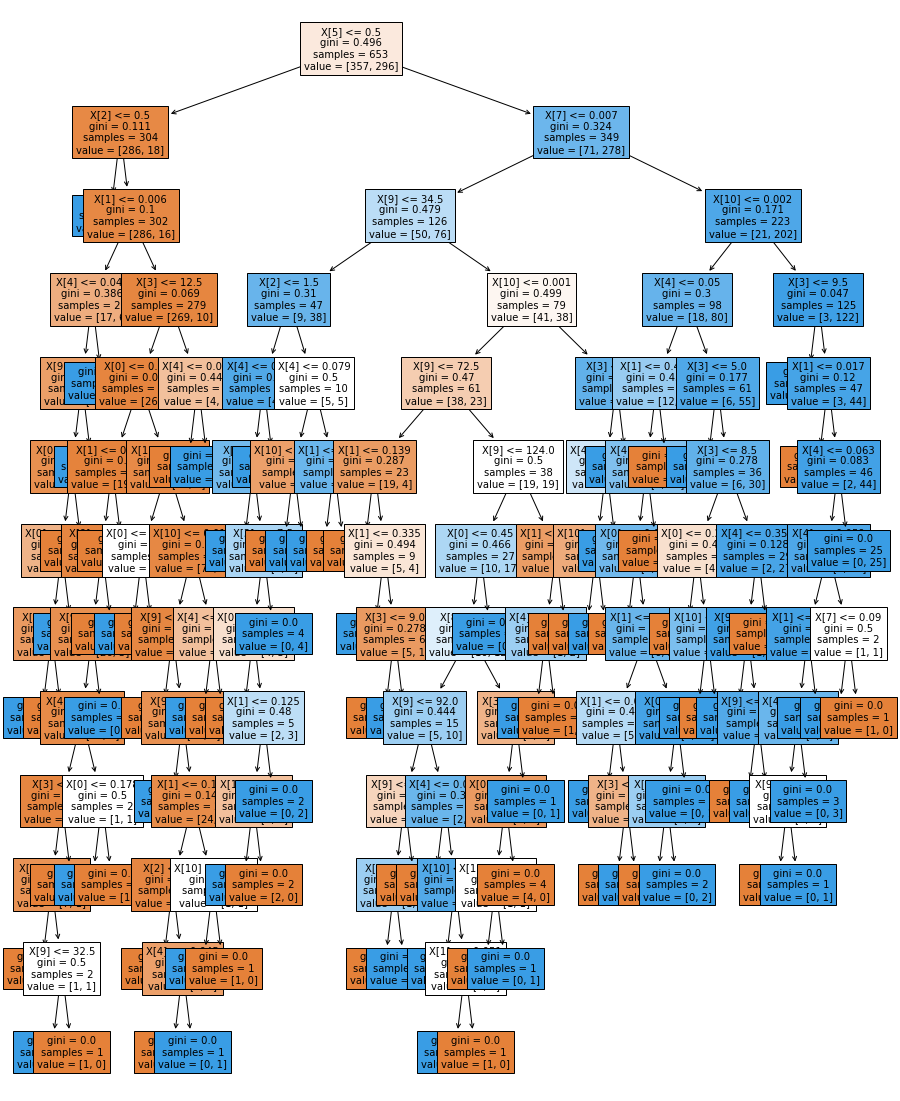

In [20]:
X, y = prepareDatasetForModeling(datasetWithRemovedRows, transformationTypes[1], hasLeastScoresFeatures = False)
model.fit(X, y)
plt.figure(figsize=(15, 20))
plot_tree(model, fontsize=10, filled=True)

In [21]:
print("\nTry an ensemble of Logistic Regression and Classification Decision Trees models of highest scores features only:")
model = VotingClassifier(estimators=[('lr', LogisticRegression(solver='lbfgs')), ('dt', DecisionTreeClassifier())], weights=[1.1,1], n_jobs=-1)
highestScoresFeaturesEnsembledTestResults = modelData(hasLeastScoresFeatures=False)


Try an ensemble of Logistic Regression and Classification Decision Trees models of highest scores features only:
Accuracy after removing missing rows: 82.271% avg (0.115 std) with none transform
Accuracy after removing missing rows: 85.811% avg (0.126 std) with normalized transform
Accuracy after removing missing rows: 85.256% avg (0.122 std) with standardized transform
Accuracy after removing missing rows: 85.211% avg (0.123 std) with log+normalized transform
Accuracy after removing missing rows: 84.798% avg (0.119 std) with log+standardized transform
Accuracy after calculating missing rows: 81.515% avg (0.101 std) with none transform
Accuracy after calculating missing rows: 84.720% avg (0.133 std) with normalized transform
Accuracy after calculating missing rows: 84.270% avg (0.127 std) with standardized transform
Accuracy after calculating missing rows: 84.310% avg (0.128 std) with log+normalized transform
Accuracy after calculating missing rows: 83.960% avg (0.124 std) with log+st


Plot test results for Logistic Regression vs Decision tree classifier models:


(78.0, 88.0)

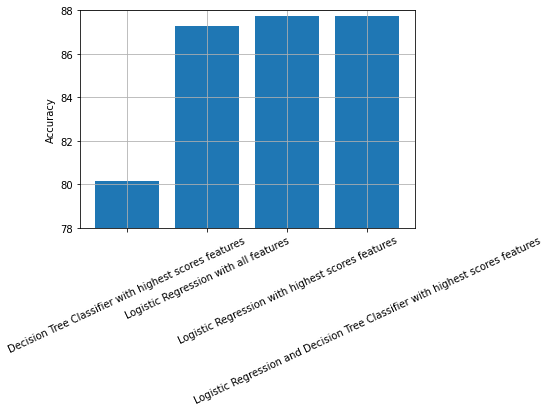

In [28]:
allResults = getAllResultsNamed()

def getHighestAccuracy(accuracies):
    return np.max(list(accuracies.values()))
    
print("\nPlot test results for Logistic Regression vs Decision tree classifier models:")
summary = {}
for modelName in models:
    summary[modelName] = getHighestAccuracy(allResults[modelName]['kFoldTransformsSummarized'])
plotSummary(summary)
plt.ylim(78, 88)

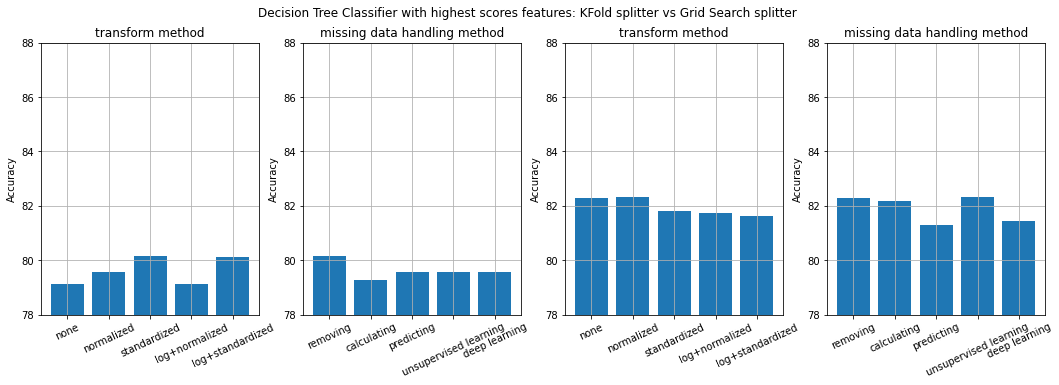

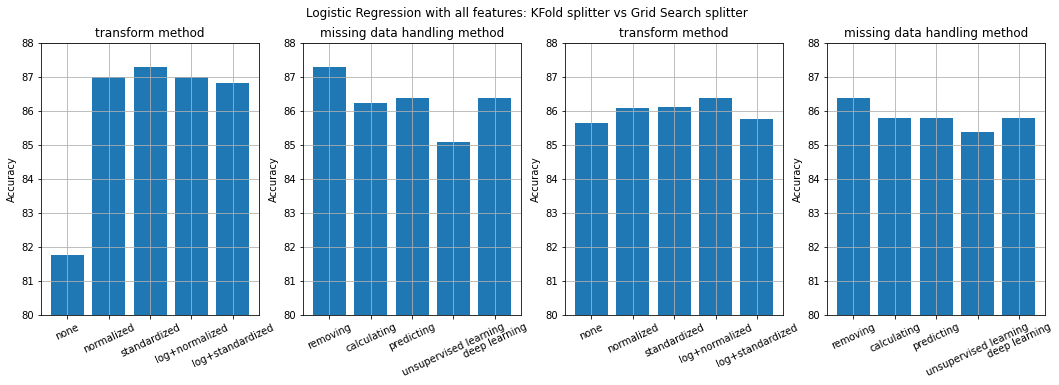

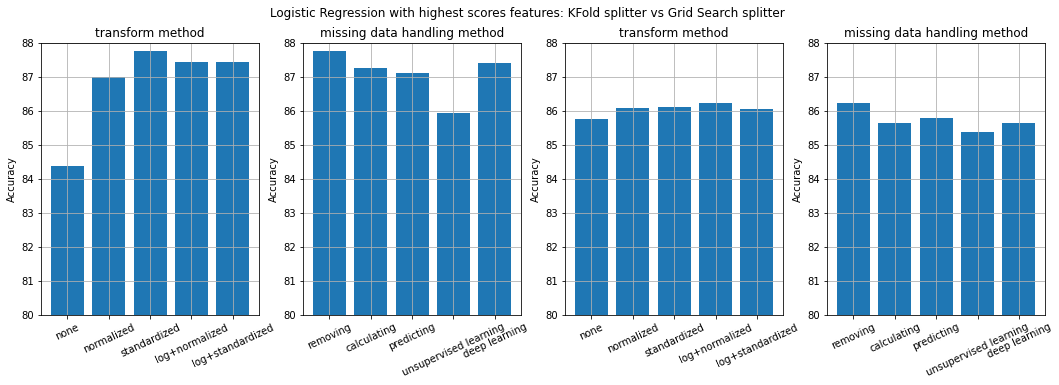

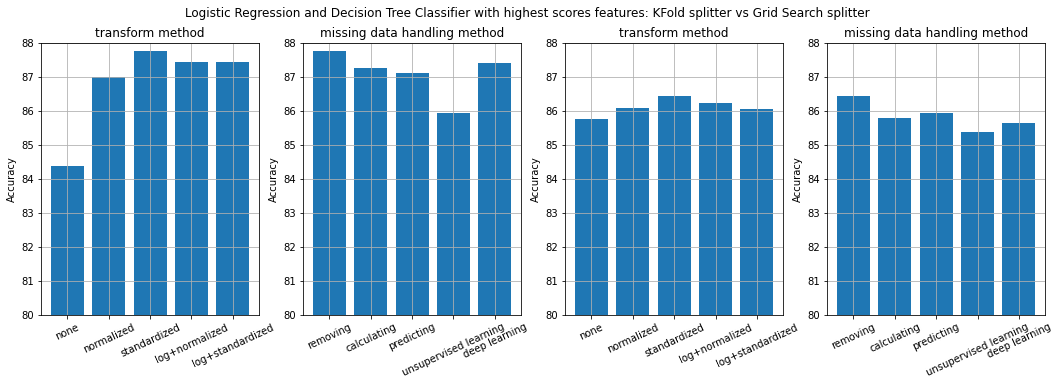

In [29]:
for modelName in models:
    ylim=(80, 88)
    if modelName == "Decision Tree Classifier with highest scores features":
        ylim=(78, 88)
    plotSummarizedResults(modelName, ylim=ylim)

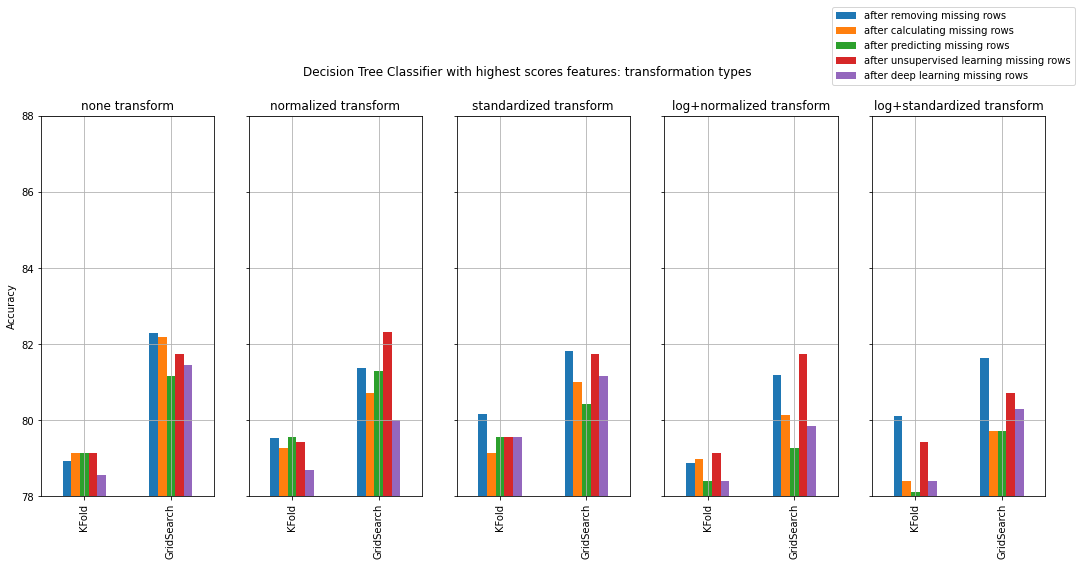

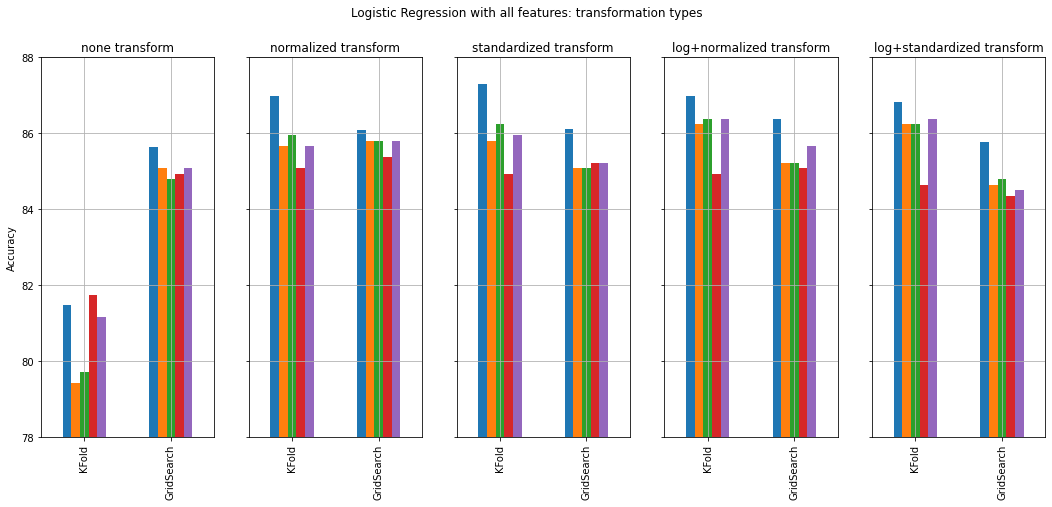

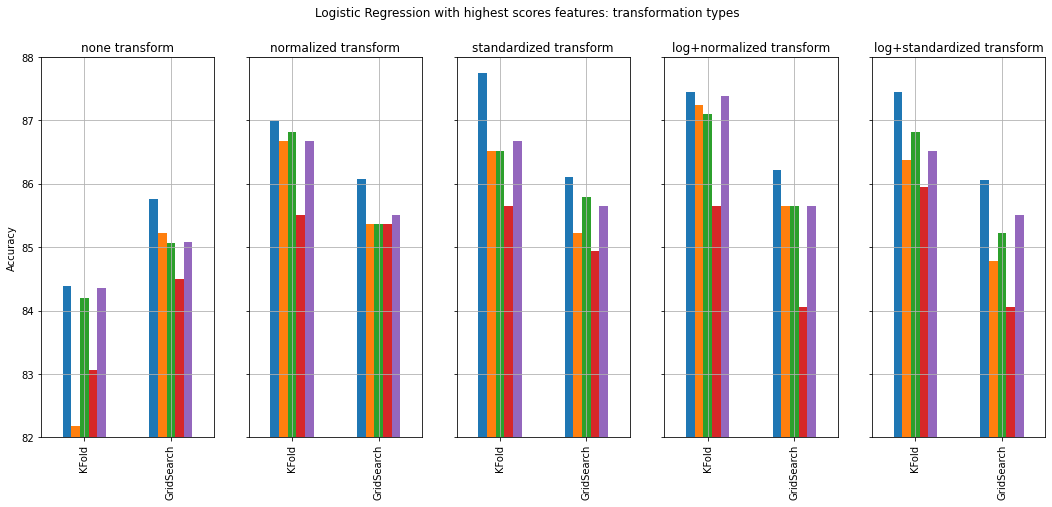

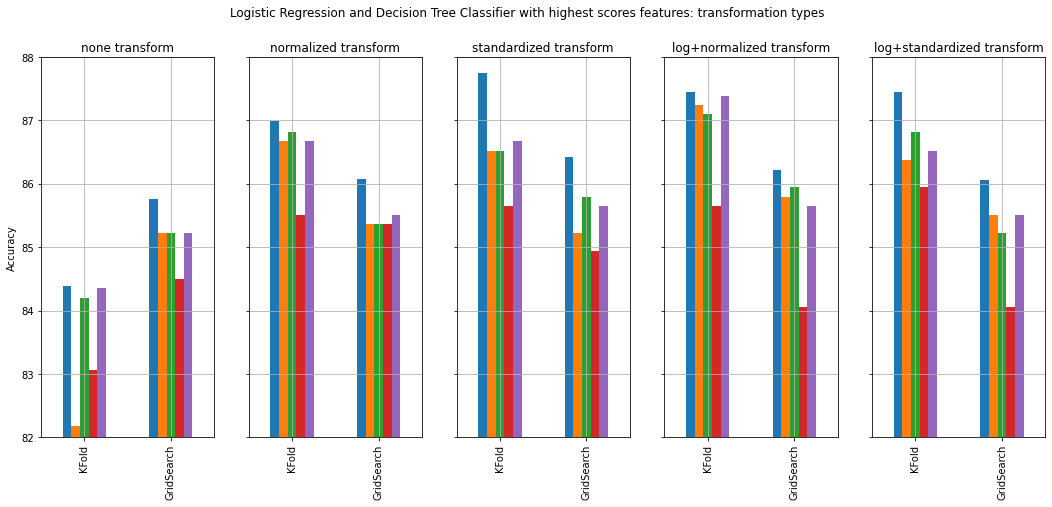

In [38]:
for modelName in models:
    ylim=(82, 88)
    legend=False
    if modelName == "Logistic Regression with all features" or modelName == "Decision Tree Classifier with highest scores features":
        ylim=(78, 88)
    if modelName == "Decision Tree Classifier with highest scores features":
        legend=True    
    plotTransformTypesSummarizedResults(modelName, ylim=ylim, legend=legend)

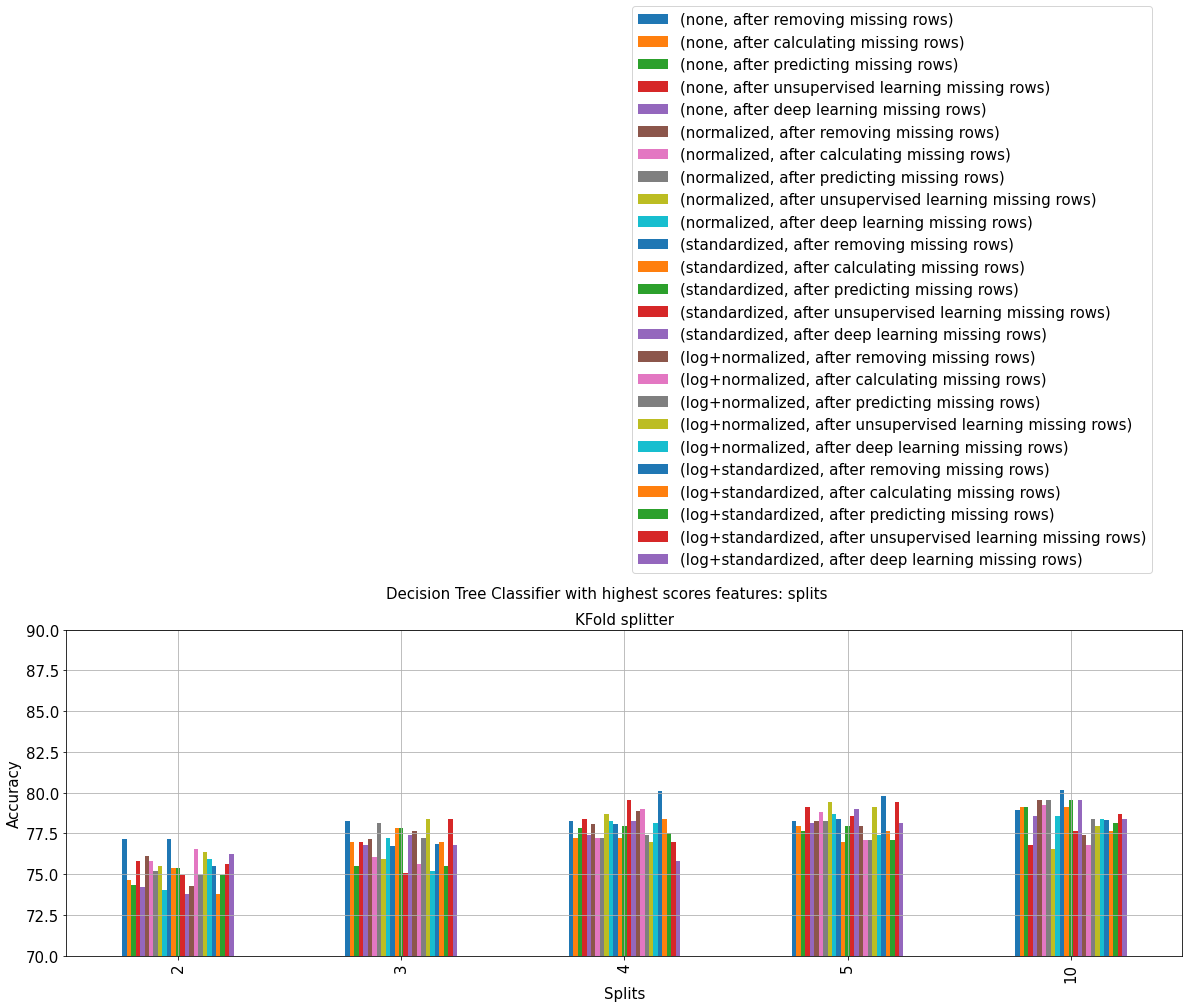

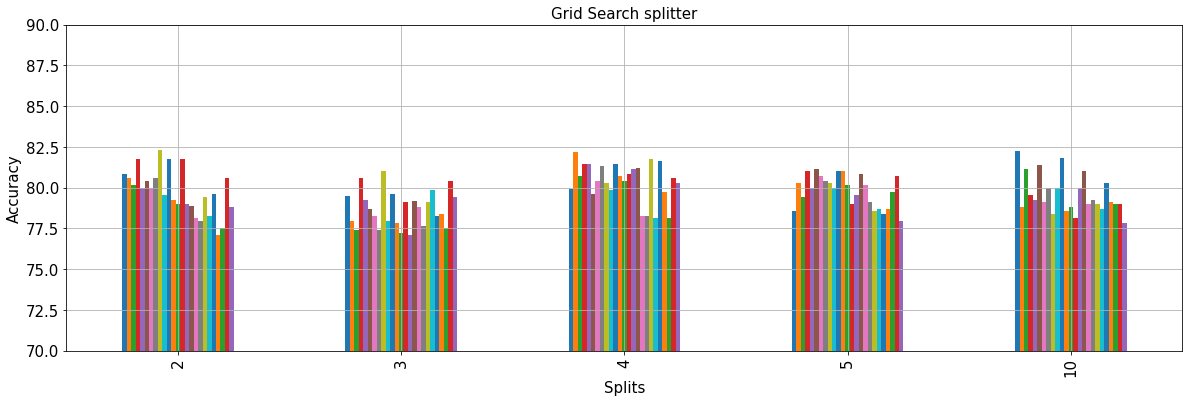

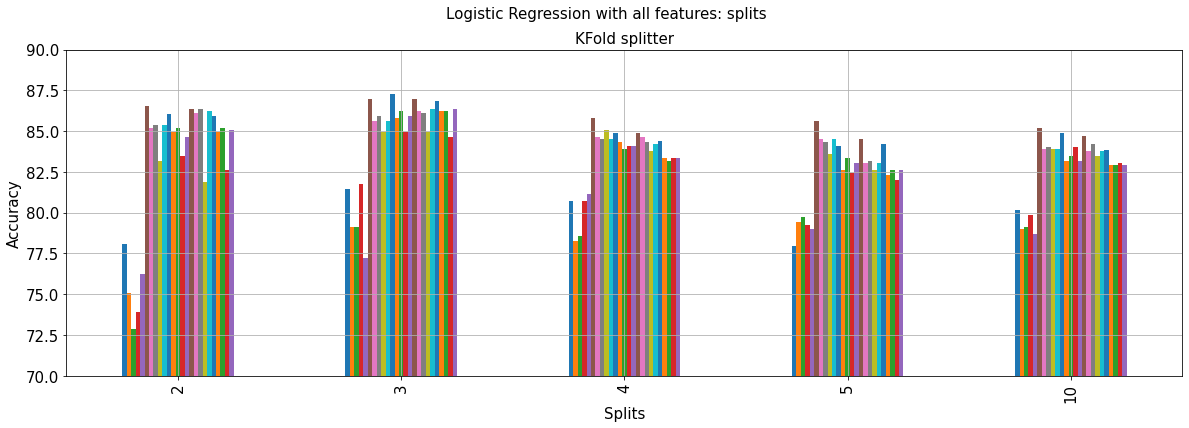

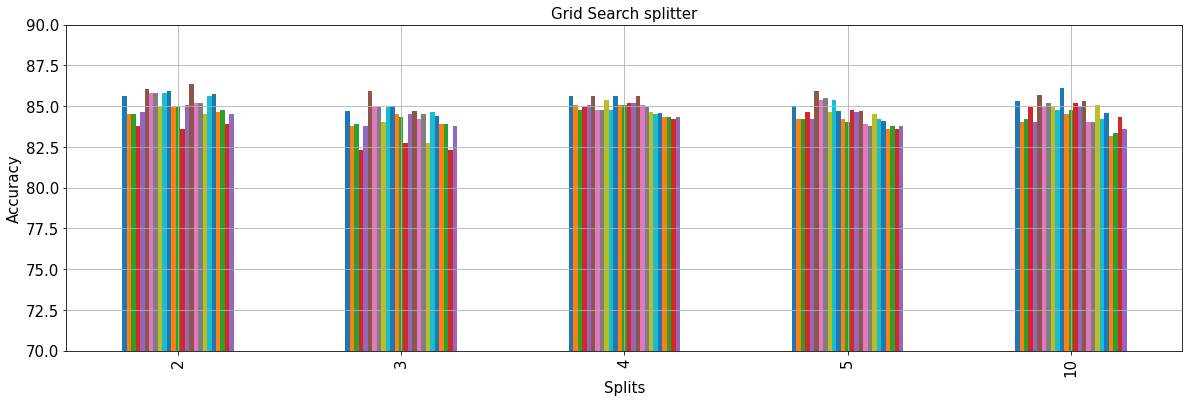

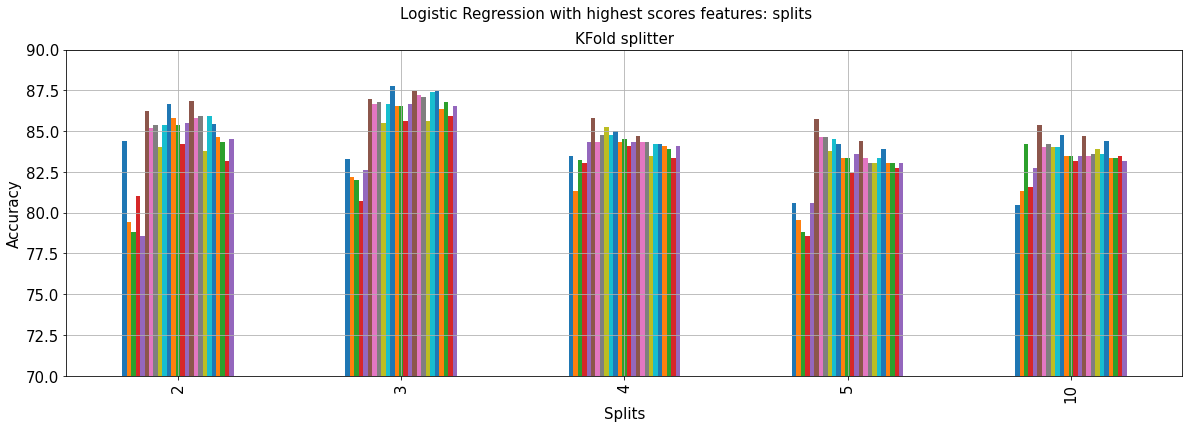

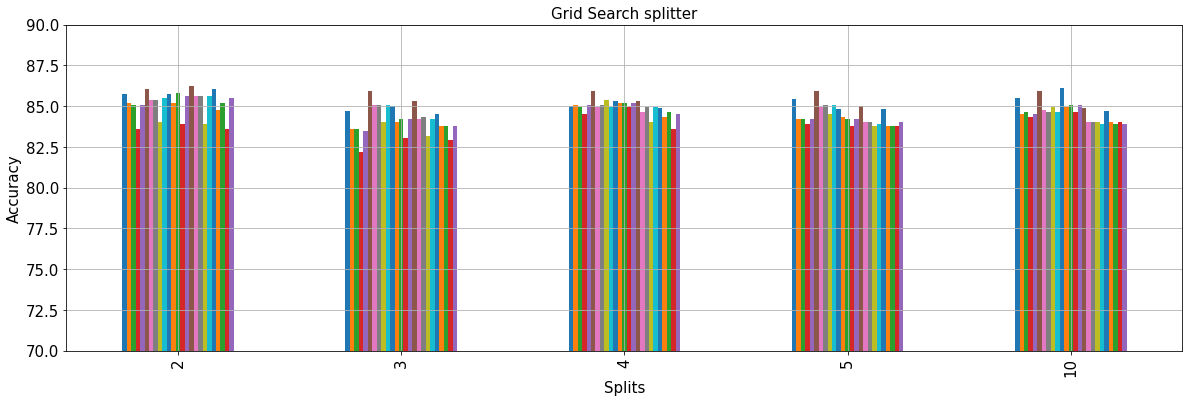

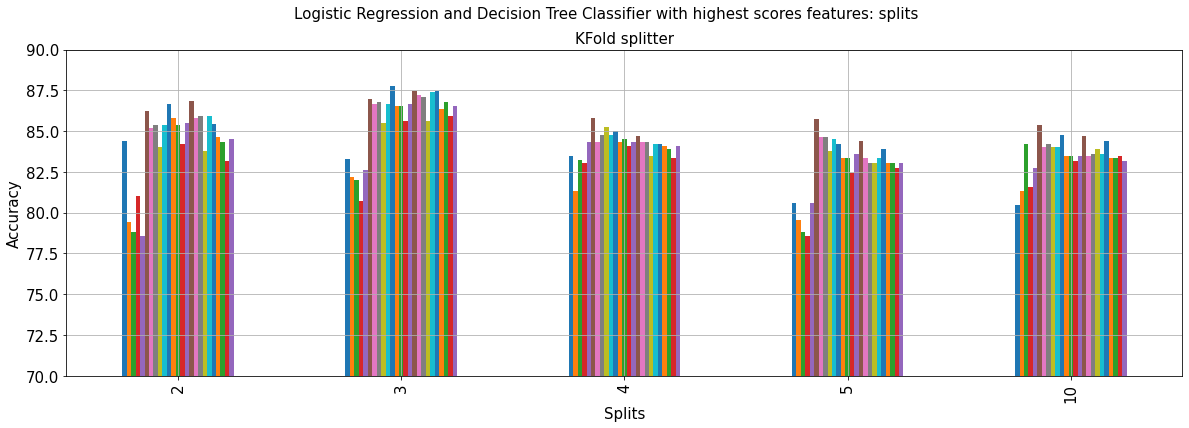

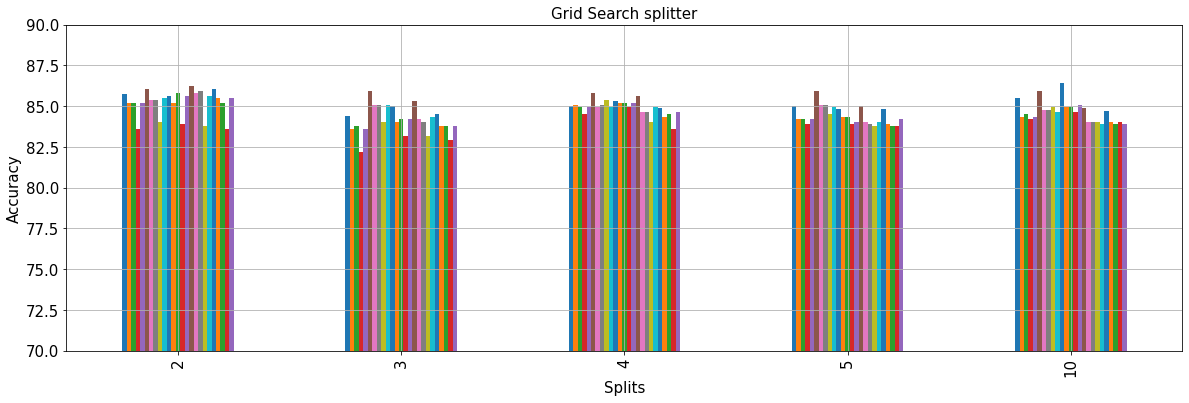

In [42]:
for modelName in models:
    legend=False
    if modelName == "Decision Tree Classifier with highest scores features":
        legend=True    
    plotDetailedResults(modelName, legend=legend)

In [34]:
for modelName in models:
    printResultsDataFrame(modelName)



 Decision Tree Classifier with highest scores features results:


none                                 \
           after removing missing rows after calculating missing rows   
KFold                           78.935                         79.130   
GridSearch                      82.282                         82.179   

                                          \
           after predicting missing rows   
KFold                             79.130   
GridSearch                        81.159   

                                                     \
           after unsupervised learning missing rows   
KFold                                        79.130   
GridSearch                                   81.739   

                                                             normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                78.551                      79.543   
GridSearch                           81.452                      81.364   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              79.275                        79.565   
GridSearch                         80.725                        81.308   

                                                     \
           after unsupervised learning missing rows   
KFold                                        79.420   
GridSearch                                   82.319   

                                                           standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                78.696                      80.161   
GridSearch                           80.000                      81.821   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              79.130                        79.565   
GridSearch                         81.014                        80.439   

                                                     \
           after unsupervised learning missing rows   
KFold                                        79.574   
GridSearch                                   81.739   

                                                         log+normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                79.565                      78.881   
GridSearch                           81.165                      81.180   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              78.992                        78.406   
GridSearch                         80.145                        79.275   

                                                     \
           after unsupervised learning missing rows   
KFold                                         79.13   
GridSearch                                    81.74   

                                                       log+standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                78.406                      80.105   
GridSearch                           79.855                      81.635   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              78.410                        78.116   
GridSearch                         79.713                        79.710   

                                                     \
           after unsupervised learning missing rows   
KFold                                        79.420   
GridSearch                                   80.725   

                                             
     


KFold results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       77.185                         74.638   
3                       78.260                         76.957   
4                       78.263                         77.252   
5                       78.264                         77.971   
10                      78.935                         79.130   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         74.348                                   75.797   
3                         75.507                                   76.957   
4                         77.831                                   78.412   
5                         77.681                                   79.130   
10                        79.130                                   76.812   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            74.203                      76.113   
3                            76.812                      77.187   
4                            77.398                      78.111   
5                            78.116                      78.262   
10                           78.551                      79.543   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          75.797                        75.217   
3                          76.087                        78.116   
4                          77.250                        77.254   
5                          78.841                        78.261   
10                         79.275                        79.565   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    75.507                           74.058   
3                                    75.942                           77.246   
4                                    78.703                           78.267   
5                                    79.420                           78.696   
10                                   76.522                           78.551   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       77.187                         75.362   
3                       76.730                         77.826   
4                       78.110                         77.252   
5                       78.412                         76.957   
10                      80.161                         79.130   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         75.362                                   74.928   
3                         77.826                                   75.072   
4                         77.979                                   79.574   
5                         77.971                                   78.551   
10                        79.565                                   77.681   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            73.768                      74.275   
3                            77.391                      77.647   
4                            78.269                      78.881   
5                            78.986                      77.953   
10                           79.565                      77.394   

                                                               


GridSearch results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       80.860                         80.580   
3                       79.476                         77.971   
4                       79.949                         82.179   
5                       78.557                         80.290   
10                      82.282                         78.841   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         80.145                                   81.739   
3                         77.391                                   80.580   
4                         80.730                                   81.452   
5                         79.420                                   81.014   
10                        81.159                                   79.565   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            80.000                      80.401   
3                            79.275                      78.710   
4                            81.452                      79.642   
5                            80.000                      81.165   
10                           79.275                      81.364   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          80.000                        80.580   
3                          78.261                        77.391   
4                          80.438                        81.308   
5                          80.725                        80.435   
10                         79.130                        80.000   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    82.319                           79.565   
3                                    81.014                           77.971   
4                                    80.293                           79.865   
5                                    80.290                           80.000   
10                                   78.406                           80.000   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       81.780                         79.275   
3                       79.630                         77.826   
4                       81.480                         80.732   
5                       81.015                         81.014   
10                      81.821                         78.551   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         78.986                                   81.739   
3                         77.246                                   79.130   
4                         80.439                                   80.870   
5                         80.145                                   78.986   
10                        78.841                                   78.116   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            78.986                      78.868   
3                            77.101                      79.170   
4                            81.165                      81.180   
5                            79.565                      80.858   
10                           80.000                      81.054   

                                                               



 Logistic Regression with all features results:


none                                 \
           after removing missing rows after calculating missing rows   
KFold                           81.475                         79.420   
GridSearch                      85.627                         85.079   

                                          \
           after predicting missing rows   
KFold                             79.710   
GridSearch                        84.788   

                                                     \
           after unsupervised learning missing rows   
KFold                                        81.739   
GridSearch                                   84.932   

                                                             normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                81.169                      86.983   
GridSearch                           85.078                      86.067   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              85.652                        85.942   
GridSearch                         85.797                        85.797   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.086   
GridSearch                                   85.368   

                                                           standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                85.652                      87.290   
GridSearch                           85.797                      86.112   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              85.797                        86.232   
GridSearch                         85.078                        85.078   

                                                     \
           after unsupervised learning missing rows   
KFold                                        84.928   
GridSearch                                   85.222   

                                                         log+normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                85.942                      86.982   
GridSearch                           85.223                      86.372   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.232                        86.377   
GridSearch                         85.217                        85.217   

                                                     \
           after unsupervised learning missing rows   
KFold                                        84.928   
GridSearch                                   85.072   

                                                       log+standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                86.377                      86.828   
GridSearch                           85.652                      85.759   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.232                        86.232   
GridSearch                         84.638                        84.783   

                                                     \
           after unsupervised learning missing rows   
KFold                                        84.638   
GridSearch                                   84.348   

                                             
     


KFold results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       78.099                         75.072   
3                       81.475                         79.130   
4                       80.720                         78.276   
5                       77.965                         79.420   
10                      80.149                         78.986   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         72.899                                   73.913   
3                         79.130                                   81.739   
4                         78.563                                   80.736   
5                         79.710                                   79.275   
10                        79.130                                   79.855   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            76.232                      86.530   
3                            77.246                      86.983   
4                            81.169                      85.778   
5                            78.986                      85.615   
10                           78.696                      85.203   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.217                        85.362   
3                          85.652                        85.942   
4                          84.649                        84.505   
5                          84.493                        84.348   
10                         83.913                        84.058   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    83.188                           85.362   
3                                    84.928                           85.652   
4                                    85.086                           84.505   
5                                    83.623                           84.493   
10                                   83.913                           83.913   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       86.070                         84.928   
3                       87.290                         85.797   
4                       84.859                         84.362   
5                       84.083                         82.609   
10                      84.895                         83.188   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.217                                   83.478   
3                         86.232                                   84.928   
4                         83.928                                   84.073   
5                         83.333                                   82.464   
10                        83.478                                   84.058   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            84.638                      86.376   
3                            85.942                      86.982   
4                            84.073                      84.859   
5                            83.043                      84.545   
10                           83.188                      84.734   

                                                               


GridSearch results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       85.607                         84.493   
3                       84.686                         83.768   
4                       85.627                         85.079   
5                       84.994                         84.203   
10                      85.345                         84.058   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         84.493                                   83.768   
3                         83.913                                   82.319   
4                         84.788                                   84.932   
5                         84.203                                   84.638   
10                        84.203                                   84.928   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            84.638                      86.067   
3                            83.768                      85.908   
4                            85.078                      85.628   
5                            84.203                      85.910   
10                           84.058                      85.655   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.797                        85.797   
3                          84.928                        84.928   
4                          84.787                        84.787   
5                          85.362                        85.507   
10                         84.928                        85.217   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    84.928                           85.797   
3                                    84.058                           84.928   
4                                    85.368                           84.787   
5                                    84.638                           85.362   
10                                   84.928                           84.783   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       85.913                         84.928   
3                       84.991                         84.493   
4                       85.627                         85.078   
5                       84.686                         84.203   
10                      86.112                         84.493   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         84.928                                   83.623   
3                         84.348                                   82.754   
4                         85.078                                   85.222   
5                         84.058                                   84.783   
10                        84.783                                   85.217   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.072                      86.372   
3                            84.493                      84.683   
4                            85.223                      85.628   
5                            84.638                      84.682   
10                           84.928                      85.345   

                                                               



 Logistic Regression with highest scores features results:


none                                 \
           after removing missing rows after calculating missing rows   
KFold                           84.386                         82.174   
GridSearch                      85.760                         85.217   

                                          \
           after predicting missing rows   
KFold                             84.203   
GridSearch                        85.072   

                                                     \
           after unsupervised learning missing rows   
KFold                                        83.060   
GridSearch                                   84.497   

                                                             normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                84.359                      86.983   
GridSearch                           85.079                      86.067   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.667                        86.812   
GridSearch                         85.362                        85.362   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.507   
GridSearch                                   85.369   

                                                           standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                86.667                      87.749   
GridSearch                           85.507                      86.114   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.522                        86.522   
GridSearch                         85.224                        85.797   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.652   
GridSearch                                   84.933   

                                                         log+normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                86.667                      87.441   
GridSearch                           85.652                      86.220   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              87.246                        87.101   
GridSearch                         85.652                        85.652   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.652   
GridSearch                                   84.060   

                                                       log+standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                87.391                      87.441   
GridSearch                           85.652                      86.065   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.377                        86.812   
GridSearch                         84.783                        85.217   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.942   
GridSearch                                   84.058   

                                             
     


KFold results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       84.386                         79.420   
3                       83.308                         82.174   
4                       83.482                         81.310   
5                       80.568                         79.565   
10                      80.476                         81.304   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         78.841                                   81.014   
3                         82.029                                   80.725   
4                         83.203                                   83.060   
5                         78.841                                   78.551   
10                        84.203                                   81.594   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            78.551                      86.224   
3                            82.609                      86.983   
4                            84.359                      85.779   
5                            80.580                      85.767   
10                           82.754                      85.354   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.217                        85.362   
3                          86.667                        86.812   
4                          84.361                        84.796   
5                          84.638                        84.638   
10                         84.058                        84.203   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    84.058                           85.362   
3                                    85.507                           86.667   
4                                    85.231                           84.796   
5                                    83.768                           84.493   
10                                   84.058                           84.058   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       86.682                         85.797   
3                       87.749                         86.522   
4                       85.013                         84.363   
5                       84.238                         83.333   
10                      84.739                         83.478   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.362                                   84.203   
3                         86.522                                   85.652   
4                         84.507                                   84.074   
5                         83.333                                   82.464   
10                        83.478                                   83.188   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.507                      86.836   
3                            86.667                      87.441   
4                            84.362                      84.707   
5                            83.623                      84.391   
10                           83.478                      84.732   

                                                               


GridSearch results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       85.760                         85.217   
3                       84.686                         83.623   
4                       85.015                         85.079   
5                       85.450                         84.203   
10                      85.501                         84.493   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.072                                   83.623   
3                         83.623                                   82.174   
4                         84.934                                   84.497   
5                         84.203                                   83.913   
10                        84.638                                   84.348   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.072                      86.067   
3                            83.478                      85.908   
4                            85.079                      85.934   
5                            84.203                      85.910   
10                           84.493                      85.960   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.362                        85.362   
3                          85.072                        85.072   
4                          84.933                        85.079   
5                          84.928                        85.072   
10                         84.783                        84.638   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    84.058                           85.507   
3                                    84.058                           85.072   
4                                    85.369                           84.934   
5                                    84.493                           85.072   
10                                   84.928                           84.638   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       85.760                         85.217   
3                       84.992                         84.058   
4                       85.321                         85.224   
5                       84.837                         84.348   
10                      86.114                         84.928   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.797                                   83.913   
3                         84.203                                   83.043   
4                         85.224                                   84.933   
5                         84.203                                   83.768   
10                        85.072                                   84.638   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.652                      86.220   
3                            84.203                      85.297   
4                            85.224                      85.321   
5                            84.203                      84.990   
10                           85.072                      84.881   

                                                               



 Logistic Regression and Decision Tree Classifier with highest scores features results:


none                                 \
           after removing missing rows after calculating missing rows   
KFold                           84.386                         82.174   
GridSearch                      85.760                         85.217   

                                          \
           after predicting missing rows   
KFold                             84.203   
GridSearch                        85.217   

                                                     \
           after unsupervised learning missing rows   
KFold                                        83.060   
GridSearch                                   84.497   

                                                             normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                84.359                      86.983   
GridSearch                           85.217                      86.067   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.667                        86.812   
GridSearch                         85.362                        85.362   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.507   
GridSearch                                   85.369   

                                                           standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                86.667                      87.749   
GridSearch                           85.507                      86.422   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.522                        86.522   
GridSearch                         85.224                        85.797   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.652   
GridSearch                                   84.933   

                                                         log+normalized  \
           after deep learning missing rows after removing missing rows   
KFold                                86.667                      87.441   
GridSearch                           85.652                      86.220   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              87.246                        87.101   
GridSearch                         85.797                        85.942   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.652   
GridSearch                                   84.060   

                                                       log+standardized  \
           after deep learning missing rows after removing missing rows   
KFold                                87.391                      87.441   
GridSearch                           85.652                      86.065   

                                                                         \
           after calculating missing rows after predicting missing rows   
KFold                              86.377                        86.812   
GridSearch                         85.507                        85.217   

                                                     \
           after unsupervised learning missing rows   
KFold                                        85.942   
GridSearch                                   84.058   

                                             
     


KFold results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       84.386                         79.420   
3                       83.308                         82.174   
4                       83.482                         81.310   
5                       80.568                         79.565   
10                      80.476                         81.304   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         78.841                                   81.014   
3                         82.029                                   80.725   
4                         83.203                                   83.060   
5                         78.841                                   78.551   
10                        84.203                                   81.594   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            78.551                      86.224   
3                            82.609                      86.983   
4                            84.359                      85.779   
5                            80.580                      85.767   
10                           82.754                      85.354   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.217                        85.362   
3                          86.667                        86.812   
4                          84.361                        84.796   
5                          84.638                        84.638   
10                         84.058                        84.203   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    84.058                           85.362   
3                                    85.507                           86.667   
4                                    85.231                           84.796   
5                                    83.768                           84.493   
10                                   84.058                           84.058   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       86.682                         85.797   
3                       87.749                         86.522   
4                       85.013                         84.363   
5                       84.238                         83.333   
10                      84.739                         83.478   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.362                                   84.203   
3                         86.522                                   85.652   
4                         84.507                                   84.074   
5                         83.333                                   82.464   
10                        83.478                                   83.188   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.507                      86.836   
3                            86.667                      87.441   
4                            84.362                      84.707   
5                            83.623                      84.391   
10                           83.478                      84.732   

                                                               


GridSearch results:


none                                 \
   after removing missing rows after calculating missing rows   
2                       85.760                         85.217   
3                       84.380                         83.623   
4                       85.015                         85.079   
5                       84.991                         84.203   
10                      85.501                         84.348   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.217                                   83.623   
3                         83.768                                   82.174   
4                         84.934                                   84.497   
5                         84.203                                   83.913   
10                        84.493                                   84.203   

                                                     normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.217                      86.067   
3                            83.623                      85.908   
4                            84.933                      85.781   
5                            84.203                      85.910   
10                           84.348                      85.960   

                                                                 \
   after calculating missing rows after predicting missing rows   
2                          85.362                        85.362   
3                          85.072                        85.072   
4                          84.933                        85.079   
5                          85.072                        85.072   
10                         84.783                        84.783   

                                                                              \
   after unsupervised learning missing rows after deep learning missing rows   
2                                    84.058                           85.507   
3                                    84.058                           85.072   
4                                    85.369                           84.934   
5                                    84.493                           84.928   
10                                   84.928                           84.638   

                  standardized                                 \
   after removing missing rows after calculating missing rows   
2                       85.606                         85.217   
3                       84.992                         84.058   
4                       85.321                         85.224   
5                       84.837                         84.348   
10                      86.422                         84.928   

                                                                           \
   after predicting missing rows after unsupervised learning missing rows   
2                         85.797                                   83.913   
3                         84.203                                   83.188   
4                         85.224                                   84.933   
5                         84.348                                   83.913   
10                        84.928                                   84.638   

                                                 log+normalized  \
   after deep learning missing rows after removing missing rows   
2                            85.652                      86.220   
3                            84.203                      85.297   
4                            85.224                      85.628   
5                            84.058                      84.990   
10                           85.072                      84.881   

                                                               